# Bayesian Logistic Regression: Red Clump Star Classification

- By Yuan-Sen Ting, March 2025, for Astron 5550

In our previous tutorial, we implemented logistic regression to classify Red Clump (RC) stars from Red Giant Branch (RGB) stars. Today, we'll extend that approach with Bayesian Logistic Regression. The standard logistic regression model we built previously provided a single best decision boundary between RC and RGB stars. However, in astronomy, understanding our uncertainty is critical.

Consider a newly observed star with a temperature and surface gravity unlike any in our training set. Standard logistic regression might confidently classify it as RC or RGB, but this confidence is unwarranted - we simply don't have enough information in that region of parameter space.

Bayesian logistic regression addresses this limitation by:

1. **Quantifying uncertainty** in our predictions, especially in regions with sparse training data
2. **Incorporating prior knowledge** about the likely shape of the decision boundary
3. **Providing distributions over possible boundaries** rather than a single "best" boundary
4. **Reducing overconfidence** in regions far from training examples

These properties are particularly valuable for RC star identification, as mistakenly classifying an RGB star as an RC star would lead to incorrect distance estimates and potentially flawed scientific conclusions.

## Learning Objectives

By working through this tutorial, you'll gain a deep understanding of Bayesian logistic regression. By the end, you will be able to:

- Understand the differences between standard and Bayesian approaches to classification
- Implement the Laplace approximation for Bayesian logistic regression
- Quantify prediction uncertainty in classification tasks
- Visualize and interpret decision boundaries with their associated uncertainties

## Prerequisites

This tutorial builds on:
- Our previous logistic regression tutorial for RC/RGB star classification
- Basic understanding of Bayesian concepts (prior, likelihood, posterior)
- Familiarity with gradient-based optimization


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Set plotting parameters for better visualization
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = (8, 5)

# For reproducibility
np.random.seed(42)

For this tutorial, we'll continue working with the APOGEE data for classifying RC vs RGB stars, but we'll focus specifically on the two most important physical parameters: effective temperature (Teff) and surface gravity (log g).

Let's load our dataset:

In [4]:
# Load the dataset
data = np.load("dataset_apogee_asteroseismic.npz")
X_full = data["data"]  # Full feature matrix
t = data["label"]      # Labels (1 for RC, 0 for RGB)

# Extract just temperature and surface gravity (first two columns)
X = X_full[:, 0:2]

print("Dataset Overview:")
print(f"Number of stars: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of RC stars: {np.sum(t == 1)}")
print(f"Number of RGB stars: {np.sum(t == 0)}")

Dataset Overview:
Number of stars: 2855
Number of features: 2
Number of RC stars: 2125
Number of RGB stars: 730


Let's plot the data to get a sense of the classification problem. RC stars (red) and RGB stars (blue) form distinguishable clusters in temperature-gravity space, though there is some overlap.

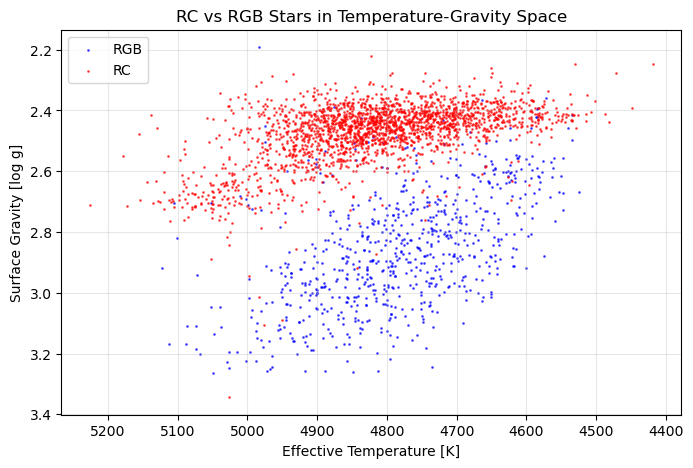

In [5]:
# Plot RGB stars (label = 0) in blue
plt.scatter(X[t == 0, 0], X[t == 0, 1], c='b', s=1, alpha=0.6, label='RGB')
# Plot Red Clump stars (label = 1) in red
plt.scatter(X[t == 1, 0], X[t == 1, 1], c='r', s=1, alpha=0.6, label='RC')

# Customize the plot
plt.gca().invert_xaxis()  
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('RC vs RGB Stars in Temperature-Gravity Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## From Standard to Bayesian Logistic Regression

In standard logistic regression, we aim to find a single "best" set of weights $\mathbf{w}$ that maximize the likelihood of our observed data. The probability of a star being RC (t=1) given features $\mathbf{x}$ is modeled as:

$$ P(t=1|\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x}) $$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.

The Bayesian approach takes this further. Instead of finding just one optimal set of weights, we:

1. Define a **prior distribution** $p(\mathbf{w})$ over the weights, representing our initial beliefs
2. Update this prior with observed data to get a **posterior distribution** $p(\mathbf{w}|\mathcal{D})$
3. Use this posterior to quantify uncertainty in our predictions

The posterior distribution is given by Bayes' rule:

$$ p(\mathbf{w}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})} $$

Where:
- $p(\mathcal{D}|\mathbf{w})$ is the likelihood of our data given the weights
- $p(\mathbf{w})$ is our prior over weights
- $p(\mathcal{D})$ is a normalization constant

For logistic regression, the likelihood is:

$$ p(\mathcal{D}|\mathbf{w}) = \prod_{n=1}^N \sigma(\mathbf{w}^T\mathbf{x}_n)^{t_n}(1-\sigma(\mathbf{w}^T\mathbf{x}_n))^{1-t_n} $$

For our prior, we'll use a multivariate Gaussian distribution:

$$ p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_0, \mathbf{S}_0) $$

Where:
- $\mathbf{m}_0$ is the prior mean vector, representing our initial belief about the most likely weights
- $\mathbf{S}_0$ is the prior covariance matrix, representing our uncertainty about these weights

In this tutorial, we'll use:
- $\mathbf{m}_0 = \mathbf{0}$ (a zero vector), which represents our belief that, in the absence of data, weights are equally likely to be positive or negative
- $\mathbf{S}_0 = \alpha^{-1} \mathbf{I}$ (scaled identity matrix), where $\alpha$ is a precision parameter controlling the strength of the prior

This yields a simplified prior:

$$ p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I}) $$

A larger $\alpha$ means a stronger preference for smaller weights, which helps prevent overfitting. This type of prior effectively performs L2 regularization (similar to Ridge regression), but within a principled Bayesian framework.

The challenge in Bayesian logistic regression is that the resulting posterior doesn't have a simple analytical form. This is because the likelihood involves the non-linear sigmoid function, which when combined with our Gaussian prior, leads to a non-Gaussian posterior.

Let's first implement the sigmoid function and prepare the data:

In [6]:
def sigmoid(z):
    """Sigmoid activation function with numerical stability."""
    # Clip to avoid overflow in exp()
    z = np.clip(z, -30, 30)
    return 1 / (1 + np.exp(-z))

# Normalize features for better numerical stability
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Split data into training and test sets
X_train, X_test, t_train, t_test = train_test_split(
    X_norm, t, test_size=0.2, random_state=46, stratify=t
)

print(f"Training set size: {len(t_train)}")
print(f"Test set size: {len(t_test)}")
print(f"Training set class distribution: {np.bincount(t_train.astype(int))}")
print(f"Test set class distribution: {np.bincount(t_test.astype(int))}")

Training set size: 2284
Test set size: 571
Training set class distribution: [ 584 1700]
Test set class distribution: [146 425]


## Finding the MAP Estimate
 
The first step in Bayesian logistic regression is finding the Maximum A Posteriori (MAP) estimate - the most probable value of the weights given the data and our prior. The MAP estimate serves as the center of our Gaussian approximation to the posterior distribution.
 
Unlike Maximum Likelihood Estimation (MLE) used in standard logistic regression, the MAP estimate includes the influence of our prior distribution. In practice, this means we're optimizing the log posterior instead of just the log likelihood:
 
$$ \log p(\mathbf{w}|\mathcal{D}) \propto \log p(\mathcal{D}|\mathbf{w}) + \log p(\mathbf{w}) $$
 
For our Gaussian prior, the log prior term is proportional to $-\frac{\alpha}{2}\|\mathbf{w}\|^2$, which is equivalent to L2 regularization with regularization strength $\alpha$.
 
In our implementation, we'll use a moderate value for $\alpha$ that provides a balanced level of regularization - not too strong to overly constrain the model, and not too weak to be ineffective. Later in this tutorial, we'll explore how different values of $\alpha$ affect our model's performance and posterior uncertainty.
 
We'll use mini-batch gradient descent to find the MAP estimate. Let's first define helper functions for creating mini-batches, computing cost, and calculating gradients:


In [7]:
def create_mini_batches(X, t, batch_size):
    """Create mini-batches from data."""
    indices = np.random.permutation(len(t))
    n_batches = len(t) // batch_size

    mini_batches = []
    for i in range(n_batches):
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]
        mini_batches.append((X[batch_indices], t[batch_indices]))

    # Handle the case where len(t) is not a multiple of batch_size
    if len(t) % batch_size != 0:
        batch_indices = indices[n_batches * batch_size:]
        mini_batches.append((X[batch_indices], t[batch_indices]))

    return mini_batches

def cost(w, X, t, N):
    """Negative log-likelihood cost function."""
    z = X @ w
    y = sigmoid(z)
    return -np.sum(t * np.log(y + 1e-15) +
                  (1 - t) * np.log(1 - y + 1e-15)) / N

Now, let's implement the training function for Bayesian logistic regression. The key difference from standard logistic regression is the addition of the prior term in the gradient:

In standard logistic regression, the gradient is just the gradient of the negative log-likelihood:
$$ \nabla_{\mathbf{w}} (-\log p(\mathcal{D}|\mathbf{w})) = \sum_{n=1}^N (\sigma(\mathbf{w}^T\mathbf{x}_n) - t_n)\mathbf{x}_n $$

In Bayesian logistic regression, we add the gradient of the negative log-prior:
$$ \nabla_{\mathbf{w}} (-\log p(\mathbf{w})) = \alpha\mathbf{w} $$

This combined gradient guides us toward the MAP estimate, which balances fitting the data with the regularizing influence of the prior.

In [8]:
def find_map_estimate(X_train, t_train, X_test, t_test, learning_rate, n_epochs, batch_size, alpha):
    """
    Find the Maximum A Posteriori (MAP) estimate for logistic regression with a Gaussian prior.
    
    Note: This function only finds the MAP point estimate, not the full Bayesian posterior.
    The MAP estimate will serve as the center of our Laplace approximation.
    
    Parameters:
    -----------
    X_train : array-like
        Training feature matrix
    t_train : array-like
        Training targets (binary)
    X_test : array-like
        Test feature matrix
    t_test : array-like
        Test targets (binary)
    learning_rate : float
        Learning rate for gradient descent
    n_epochs : int
        Number of epochs to train
    batch_size : int
        Mini-batch size
    alpha : float
        Precision parameter for Gaussian prior
    """
    N, M = X_train.shape
    w = np.random.normal(0, 0.1, M)  # Initialize weights
    train_loss_history = []
    test_loss_history = []

    print(f"Finding MAP estimate with prior precision alpha={alpha}...")
    for epoch in range(n_epochs):
        mini_batches = create_mini_batches(X_train, t_train, batch_size)

        for X_batch, t_batch in mini_batches:
            # Forward pass: compute predictions
            z_batch = X_batch @ w
            y_batch = sigmoid(z_batch)
            
            # Compute gradient of negative log-likelihood
            grad_nll = X_batch.T @ (y_batch - t_batch) / len(t_batch)
            
            # Compute gradient of negative log-prior (Gaussian prior)
            grad_prior = alpha * w / len(t_batch)
            
            # Combined gradient (negative log posterior)
            grad_posterior = grad_nll + grad_prior
            
            # Update weights
            w = w - learning_rate * grad_posterior

        # Compute loss after each epoch
        train_loss = cost(w, X_train, t_train, len(t_train))
        test_loss = cost(w, X_test, t_test, len(t_test))
        
        # Track loss history
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    return w, train_loss_history, test_loss_history

Finding MAP estimate with prior precision alpha=0.1...
Epoch 0: Train Loss = 0.3810, Test Loss = 0.3956
Epoch 20: Train Loss = 0.2403, Test Loss = 0.2504
Epoch 40: Train Loss = 0.2387, Test Loss = 0.2485
Epoch 60: Train Loss = 0.2385, Test Loss = 0.2482
Epoch 80: Train Loss = 0.2386, Test Loss = 0.2483
Epoch 100: Train Loss = 0.2385, Test Loss = 0.2483
Epoch 120: Train Loss = 0.2386, Test Loss = 0.2483
Epoch 140: Train Loss = 0.2385, Test Loss = 0.2482
Epoch 160: Train Loss = 0.2385, Test Loss = 0.2482
Epoch 180: Train Loss = 0.2385, Test Loss = 0.2483


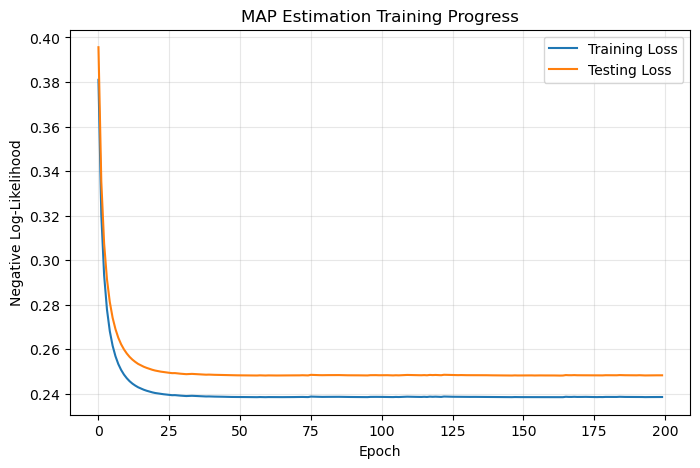

In [9]:
# Set hyperparameters
learning_rate = 0.1
n_epochs = 200
batch_size = 32
alpha = 0.1  # Prior precision parameter

# Find the MAP estimate (point estimate with prior regularization)
w_map, train_losses, test_losses = find_map_estimate(
    X_train, t_train, X_test, t_test, 
    learning_rate, n_epochs, batch_size, alpha
)

# Plot training and testing loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('MAP Estimation Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Visualizing the MAP Decision Boundary

Now that we've found the MAP estimate, let's visualize the decision boundary it creates. Remember that at this stage, we still only have a single "best" decision boundary - we haven't yet quantified our uncertainty around this boundary.

This visualization shows:
1. The MAP decision boundary (where probability = 0.5)
2. The probability contours across the feature space based on the MAP estimate
3. The correctly and incorrectly classified test data points

This will serve as our baseline before we incorporate uncertainty through the Laplace approximation.


/var/folders/8k/tycyb3r937bfwhfdhcckv4vm0000gn/T/ipykernel_84420/2656422430.py:44: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx_orig, yy_orig, grid_probs, levels=[0.5], colors='k', linewidths=2,


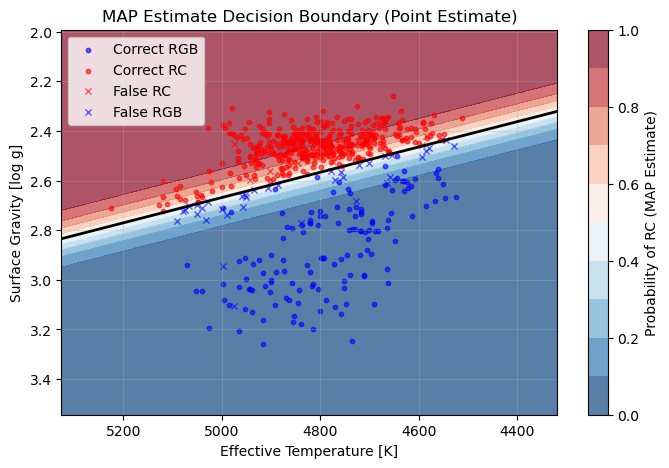

In [10]:
# Helper function for prediction
def predict(w, X):
    probs = sigmoid(X @ w)
    return (probs > 0.5).astype(int), probs

# Create a grid in original feature space
Teff_min, Teff_max = X[:, 0].min() - 100, X[:, 0].max() + 100
logg_min, logg_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx_orig, yy_orig = np.meshgrid(np.linspace(Teff_min, Teff_max, 100),
                              np.linspace(logg_min, logg_max, 100))

# Normalize the grid points (to match our normalized training data)
xx_norm = (xx_orig - X_mean[0]) / X_std[0]
yy_norm = (yy_orig - X_mean[1]) / X_std[1]
grid_points_norm = np.c_[xx_norm.ravel(), yy_norm.ravel()]

# Make predictions on the grid using the MAP estimate
grid_probs = sigmoid(grid_points_norm @ w_map)
grid_probs = grid_probs.reshape(xx_orig.shape)

# Make predictions on test set
X_test_orig = X_test * X_std + X_mean  # Convert test points back to original scale
test_pred, test_probs = predict(w_map, X_test)
misclassified = test_pred != t_test

# Create contour plot for probabilities
contour = plt.contourf(xx_orig, yy_orig, grid_probs, levels=np.linspace(0, 1, 11), 
                       cmap='RdBu_r', alpha=0.7)
plt.colorbar(contour, label='Probability of RC (MAP Estimate)')

# Plot correctly classified test points
plt.scatter(X_test_orig[~misclassified & (t_test == 0), 0], X_test_orig[~misclassified & (t_test == 0), 1], 
           c='blue', s=10, alpha=0.6, label='Correct RGB')
plt.scatter(X_test_orig[~misclassified & (t_test == 1), 0], X_test_orig[~misclassified & (t_test == 1), 1], 
           c='red', s=10, alpha=0.6, label='Correct RC')

# Highlight misclassified test points
plt.scatter(X_test_orig[misclassified & (t_test == 0), 0], X_test_orig[misclassified & (t_test == 0), 1], 
           c='red', s=20, alpha=0.6, marker='x', linewidths=1, label='False RC')
plt.scatter(X_test_orig[misclassified & (t_test == 1), 0], X_test_orig[misclassified & (t_test == 1), 1], 
           c='blue', s=20, alpha=0.6, marker='x', linewidths=1, label='False RGB')

# Draw the decision boundary (probability = 0.5)
plt.contour(xx_orig, yy_orig, grid_probs, levels=[0.5], colors='k', linewidths=2, 
            linestyles='solid', label='MAP Decision Boundary')

# Customize the plot
plt.gca().invert_xaxis()  # Astronomers typically plot temperature with hotter stars on the left
plt.gca().invert_yaxis()  # Lower log(g) values (giants) on top
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('MAP Estimate Decision Boundary (Point Estimate)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## The Laplace Approximation

One of the key challenges in Bayesian logistic regression is that the posterior distribution doesn't have a simple analytical form. Unlike Bayesian linear regression with Gaussian priors and likelihood, the non-linear sigmoid function in logistic regression leads to a complex, non-Gaussian posterior distribution.

The **Laplace approximation** provides an elegant solution to this problem by approximating the posterior with a Gaussian distribution centered at the Maximum A Posteriori (MAP) estimate. This approach was discussed in our lecture and is based on a second-order Taylor expansion of the log posterior around its mode.

The Laplace approximation works as follows:

1. At the MAP estimate $\mathbf{w}_{\text{MAP}}$, the log posterior has a peak (where the gradient is zero)
2. Near this peak, the log posterior can be approximated by a quadratic function (similar to a parabola in 1D)
3. A quadratic function in the log domain corresponds to a Gaussian in the original domain

The resulting approximation is:

$$ p(\mathbf{w}|\mathcal{D}) \approx \mathcal{N}(\mathbf{w}|\mathbf{w}_{\text{MAP}}, \mathbf{A}^{-1}) $$

Where $\mathbf{A}$ is the Hessian matrix of the negative log posterior evaluated at $\mathbf{w}_{\text{MAP}}$. This matrix captures the curvature of the posterior at its peak. A sharper peak (larger curvature) corresponds to a narrower Gaussian (smaller variance), reflecting higher certainty in our parameter estimates.

For logistic regression, the Hessian has a special structure:

$$ \mathbf{A} = \nabla\nabla (-\log p(\mathbf{w}|\mathcal{D})) |_{\mathbf{w}=\mathbf{w}_{\text{MAP}}} = \alpha\mathbf{I} + \sum_{n=1}^N \sigma(\mathbf{w}_{\text{MAP}}^T\mathbf{x}_n)(1-\sigma(\mathbf{w}_{\text{MAP}}^T\mathbf{x}_n))\mathbf{x}_n\mathbf{x}_n^T $$

This equation shows that the Hessian combines:
- The prior precision $\alpha\mathbf{I}$ (from our Gaussian prior)
- A data-dependent term where each observation contributes according to its prediction uncertainty

In [11]:
def compute_hessian(w, X, t, alpha):
    """
    Compute the Hessian of the negative log posterior at the MAP estimate.
    
    The Hessian captures the curvature of the posterior at its peak, which
    determines the covariance of our Gaussian approximation.
    
    Parameters:
    -----------
    w : array-like
        Weight vector at MAP estimate
    X : array-like
        Feature matrix
    t : array-like
        Target binary labels
    alpha : float
        Precision parameter for Gaussian prior
    
    Returns:
    --------
    hessian : array-like
        Hessian matrix of negative log posterior
    """
    n_features = X.shape[1]
    
    # Compute predictions
    z = X @ w
    y = sigmoid(z)
    
    # Hessian computation - combine data term and prior term
    hessian = np.zeros((n_features, n_features))
    
    # Data term: Each observation contributes to the Hessian
    for i in range(len(t)):
        x_i = X[i, :].reshape(-1, 1)  # Make column vector
        r_i = y[i] * (1 - y[i])       # Second derivative of log-likelihood
        hessian += r_i * (x_i @ x_i.T)  # Outer product
    
    # Prior term: Add contribution from Gaussian prior
    hessian += alpha * np.eye(n_features)
    
    return hessian

# Compute the Hessian at the MAP estimate
hessian = compute_hessian(w_map, X_train, t_train, alpha)

# Compute the covariance matrix (inverse of Hessian)
cov_matrix = np.linalg.inv(hessian)

print("Hessian matrix:")
print(hessian)
print("\nCovariance matrix (inverse Hessian):")
print(cov_matrix)

# Extract the standard deviations of the weights
weight_std = np.sqrt(np.diag(cov_matrix))
print("\nMAP weights with uncertainty:")
print(f"Weight 0 (Temperature): {w_map[0]:.4f} ± {weight_std[0]:.4f}")
print(f"Weight 1 (Surface Gravity): {w_map[1]:.4f} ± {weight_std[1]:.4f}")

# Compute the correlation between weights
correlation = cov_matrix[0, 1] / (weight_std[0] * weight_std[1])
print(f"\nCorrelation between weights: {correlation:.4f}")

Hessian matrix:
[[274.29123226  83.7001179 ]
 [ 83.7001179   61.24054398]]

Covariance matrix (inverse Hessian):
[[ 0.00625412 -0.00854778]
 [-0.00854778  0.02801167]]

MAP weights with uncertainty:
Weight 0 (Temperature): 1.2042 ± 0.0791
Weight 1 (Surface Gravity): -4.0592 ± 0.1674

Correlation between weights: -0.6458


## Sampling from the Posterior Distribution

Now that we have a Gaussian approximation to the posterior distribution, we can sample from it to visualize the uncertainty in our model. This is a key advantage of the Bayesian approach - instead of having a single decision boundary, we have a distribution over possible boundaries.

Each sample from the posterior represents a different set of weights, which in turn defines a different decision boundary. By visualizing multiple boundaries, we can get a sense of the model's uncertainty in different regions of the feature space.

Regions where the sampled boundaries are tightly clustered indicate high confidence in the classification. Regions where the boundaries are more spread out indicate greater uncertainty.

First 5 sampled weight vectors:
Sample 1: Temperature = 1.1682, Log g = -3.9792
Sample 2: Temperature = 1.2496, Log g = -3.9229
Sample 3: Temperature = 1.2050, Log g = -4.1026
Sample 4: Temperature = 1.1550, Log g = -3.7822
Sample 5: Temperature = 1.2607, Log g = -4.1271


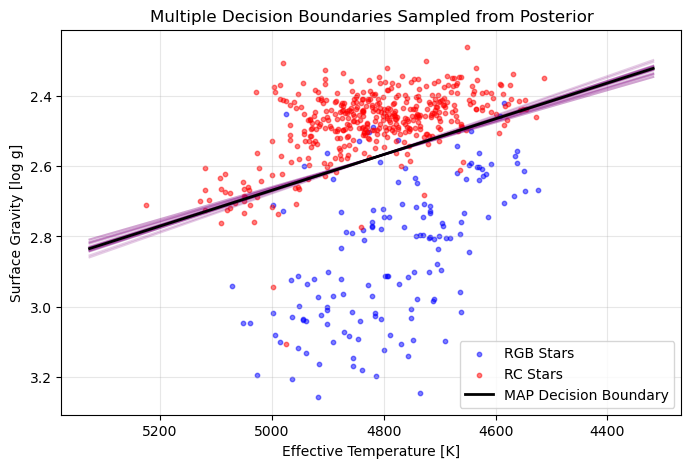

In [12]:
def sample_from_posterior(w_map, cov_matrix, n_samples=20):
    """
    Sample weight vectors from the Gaussian approximation of the posterior.
    
    Parameters:
    -----------
    w_map : array-like
        MAP estimate (mean of Gaussian approximation)
    cov_matrix : array-like
        Covariance matrix (from inverse Hessian)
    n_samples : int
        Number of samples to draw
        
    Returns:
    --------
    samples : array-like
        Sampled weight vectors
    """
    return np.random.multivariate_normal(w_map, cov_matrix, size=n_samples)

# Set seed for reproducibility
np.random.seed(42)

# Draw 20 samples from the posterior
weight_samples = sample_from_posterior(w_map, cov_matrix, n_samples=20)

# Print a few samples to see the variation
print("First 5 sampled weight vectors:")
for i in range(5):
    print(f"Sample {i+1}: Temperature = {weight_samples[i, 0]:.4f}, Log g = {weight_samples[i, 1]:.4f}")


# Convert test points back to original scale for plotting
X_test_orig = X_test * X_std + X_mean

# Plot test data points
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], 
           c='blue', s=10, alpha=0.5, label='RGB Stars')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], 
           c='red', s=10, alpha=0.5, label='RC Stars')

# Create original-scale grid for the x-axis (temperature)
x_grid_orig = np.linspace(X[:, 0].min() - 100, X[:, 0].max() + 100, 100)

# Plot decision boundaries for each sampled weight vector
for i in range(len(weight_samples)):
    w_sample = weight_samples[i]
    
    # For each x point, find the corresponding y value where the decision boundary lies
    # The decision boundary is where w[0]*x_norm + w[1]*y_norm = 0
    # First, normalize the x values
    x_grid_norm = (x_grid_orig - X_mean[0]) / X_std[0]
    
    # Solve for y_norm: y_norm = -w[0]*x_norm / w[1]
    y_grid_norm = -w_sample[0] * x_grid_norm / w_sample[1]
    
    # Convert y back to original scale
    y_grid_orig = y_grid_norm * X_std[1] + X_mean[1]
    
    # Plot this decision boundary
    plt.plot(x_grid_orig, y_grid_orig, 'purple', alpha=0.2)

# Also plot the MAP decision boundary in black
y_grid_norm_map = -w_map[0] * x_grid_norm / w_map[1]
y_grid_orig_map = y_grid_norm_map * X_std[1] + X_mean[1]
plt.plot(x_grid_orig, y_grid_orig_map, 'k', linewidth=2, label='MAP Decision Boundary')

# Customize the plot
plt.gca().invert_xaxis()  # Astronomers typically plot temperature with hotter stars on the left
plt.gca().invert_yaxis()  # Lower log(g) values (giants) on top
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Multiple Decision Boundaries Sampled from Posterior')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

We will use the weight samples drawn from our posterior distribution to visualize the uncertainty in our predictions across the feature space. By computing predictions for each sampled weight vector, we can:

1. Calculate the mean probability at each point in the feature space, showing our best estimate of class membership
2. Calculate the standard deviation of these probabilities, revealing regions where our model is more uncertain

This approach allows us to identify areas in the temperature-gravity space where the classification boundary between RGB and RC stars is well-defined versus regions where the model is less certain. Higher standard deviations indicate greater uncertainty in the classification, which is particularly valuable for understanding the reliability of our predictions in different regions of the parameter space.


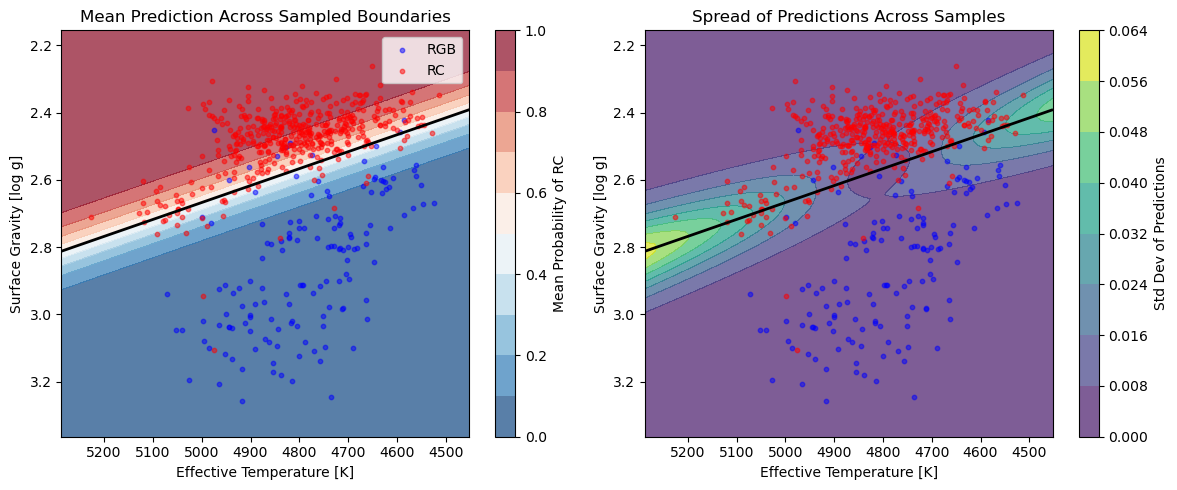

In [13]:
def visualize_multiple_predictions(X, w_samples):
    """
    Visualize the spread of predictions from multiple weight samples.
    
    Parameters:
    -----------
    X : array-like
        Feature matrix (normalized)
    w_samples : array-like
        Samples from the posterior distribution
    
    Returns:
    --------
    mean_probs : array-like
        Mean probabilities across samples
    std_probs : array-like
        Standard deviations of probabilities across samples
    """
    # Compute predictions for each weight sample
    all_probs = np.zeros((len(X), len(w_samples)))
    
    for i, w in enumerate(w_samples):
        all_probs[:, i] = sigmoid(X @ w)
    
    # Compute mean and standard deviation across samples
    mean_probs = np.mean(all_probs, axis=1)
    std_probs = np.std(all_probs, axis=1)
    
    return mean_probs, std_probs

# Create a grid in normalized feature space
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx_norm, yy_norm = np.meshgrid(np.linspace(x_min, x_max, 100),
                               np.linspace(y_min, y_max, 100))

# Convert to original feature space for plotting
xx_orig = xx_norm * X_std[0] + X_mean[0]
yy_orig = yy_norm * X_std[1] + X_mean[1]

# Prepare grid points
grid_points_norm = np.c_[xx_norm.ravel(), yy_norm.ravel()]

# Visualize spread of predictions from multiple weight samples
mean_probs, std_probs = visualize_multiple_predictions(grid_points_norm, weight_samples)

# Reshape for plotting
mean_probs = mean_probs.reshape(xx_norm.shape)
std_probs = std_probs.reshape(xx_norm.shape)

# Plot the mean prediction and variance across samples
plt.figure(figsize=(12, 5))

# Left plot: Mean prediction across samples
plt.subplot(1, 2, 1)
contour = plt.contourf(xx_orig, yy_orig, mean_probs, levels=np.linspace(0, 1, 11), cmap='RdBu_r', alpha=0.7)
plt.colorbar(contour, label='Mean Probability of RC')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], c='blue', s=10, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], c='red', s=10, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, mean_probs, levels=[0.5], colors='k', linewidths=2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Mean Prediction Across Sampled Boundaries')
plt.legend()

# Right plot: Standard deviation of predictions
plt.subplot(1, 2, 2)
uncertainty = plt.contourf(xx_orig, yy_orig, std_probs, cmap='viridis', alpha=0.7)
plt.colorbar(uncertainty, label='Std Dev of Predictions')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], c='blue', s=10, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], c='red', s=10, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, mean_probs, levels=[0.5], colors='k', linewidths=2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Spread of Predictions Across Samples')

plt.tight_layout()
plt.show()

## From Sample-Based Approximation to Analytical Predictive Distribution

The sampling approach we just used provides an intuitive way to visualize prediction uncertainty. But a more elegant approach is to use the probit approximation, which gives us an analytical form for the predictive distribution. As we learned in the lecture, the predictive distribution for Bayesian logistic regression can be approximated as:

$$ p(t_*=1|\mathbf{x}_*, \mathcal{D}) \approx \sigma\left(\frac{\mu_a}{\sqrt{1 + \pi\sigma_a^2/8}}\right) $$

Where:
- $\mu_a = \mathbf{w}_{\text{MAP}}^T \mathbf{x}_*$ is the MAP prediction
- $\sigma_a^2 = \mathbf{x}_*^T \mathbf{A}^{-1} \mathbf{x}_*$ is the variance of the prediction

The term $\kappa = 1/\sqrt{1 + \pi\sigma_a^2/8}$ acts as an "uncertainty factor" that automatically pushes predictions toward 0.5 (maximum uncertainty) in regions of feature space with high uncertainty.

Let's implement this probit approximation to compute the predictive distribution:

In [14]:
def compute_predictive_distribution_probit(X, w_map, cov_matrix):
    """
    Compute Bayesian predictive distribution using the probit approximation.
    
    Parameters:
    -----------
    X : array-like
        Feature matrix
    w_map : array-like
        MAP estimate of weights
    cov_matrix : array-like
        Covariance matrix (inverse Hessian)
        
    Returns:
    --------
    pred_probs : array-like
        Predictive probabilities
    uncertainty : array-like
        Uncertainty measure (standard deviation)
    std_dev : array-like
        Standard deviation of the linear predictor
    kappa : array-like
        Uncertainty factor
    """
    # Compute MAP predictions
    mu = X @ w_map
    
    # Compute prediction variance (This is the variance of a = w^T x)
    var = np.zeros(len(X))
    for i in range(len(X)):
        x_i = X[i].reshape(-1, 1)
        var[i] = (x_i.T @ cov_matrix @ x_i)[0, 0]  # Extract scalar from 1x1 matrix
    
    # Compute uncertainty factor (kappa)
    kappa = 1.0 / np.sqrt(1.0 + np.pi * var / 8.0)
    
    # Compute predictive probabilities using probit approximation
    pred_probs = sigmoid(kappa * mu)
    
    # Alternative measure of uncertainty: 
    # How much does the probability change from MAP to predictive distribution?
    map_probs = sigmoid(mu)
    uncertainty = np.abs(pred_probs - map_probs)
    
    # Also return the raw standard deviation for comparison
    std_dev = np.sqrt(var)
    
    return pred_probs, uncertainty, std_dev, kappa

# Create a grid for visualization
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx_norm, yy_norm = np.meshgrid(np.linspace(x_min, x_max, 100),
                              np.linspace(y_min, y_max, 100))
xx_orig = xx_norm * X_std[0] + X_mean[0]
yy_orig = yy_norm * X_std[1] + X_mean[1]

# Prepare grid points
grid_points_norm = np.c_[xx_norm.ravel(), yy_norm.ravel()]

# Compute predictive distribution using probit approximation
pred_probs, uncertainty, std_dev, kappa_values = compute_predictive_distribution_probit(
    grid_points_norm, w_map, cov_matrix
)

# Reshape for plotting
pred_probs = pred_probs.reshape(xx_norm.shape)
uncertainty = uncertainty.reshape(xx_norm.shape)
std_dev = std_dev.reshape(xx_norm.shape)
kappa_values = kappa_values.reshape(xx_norm.shape)


The kappa (κ) parameter is a critical part of the probit approximation in Bayesian logistic regression. It functions as an "uncertainty factor" that modulates our predictions based on parameter uncertainty.

Let's examine two key visualizations to better understand how Bayesian logistic regression quantifies uncertainty:

1. **Prediction Uncertainty**: This shows the difference between the MAP predictions and the Bayesian predictive distribution (|Pred - MAP|). Larger values indicate areas where incorporating uncertainty has the biggest impact on our predictions.

2. **Uncertainty Factor (κ)**: This factor ranges from 0 to 1 and directly controls how much the predictions are shifted toward uncertainty. When κ is close to 1, the Bayesian predictions are similar to MAP predictions. As κ decreases, predictions are pushed toward 0.5 (maximum uncertainty).

The spatial patterns in these visualizations reveal how our model's certainty varies across the feature space.

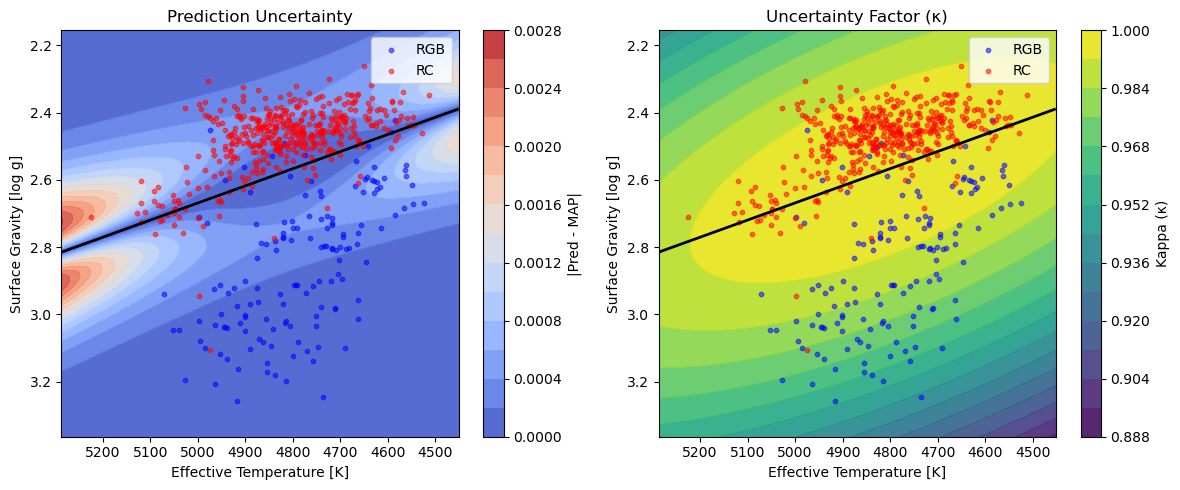

In [15]:
# Visualize prediction uncertainty and uncertainty factor (kappa)
plt.figure(figsize=(12, 5))

# Plot 1: Prediction Uncertainty
plt.subplot(1, 2, 1)
unc_plot = plt.contourf(xx_orig, yy_orig, uncertainty, cmap='coolwarm', alpha=0.9, levels=15)
plt.colorbar(unc_plot, label='|Pred - MAP|')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], c='blue', s=10, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], c='red', s=10, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, pred_probs, levels=[0.5], colors='k', linewidths=2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Prediction Uncertainty')
plt.legend()

# Plot 2: Kappa values with viridis color scheme
plt.subplot(1, 2, 2)
kappa_plot = plt.contourf(xx_orig, yy_orig, kappa_values, cmap='viridis', alpha=0.9, levels=15)
plt.colorbar(kappa_plot, label='Kappa (κ)')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], c='blue', s=10, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], c='red', s=10, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, pred_probs, levels=[0.5], colors='k', linewidths=2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Uncertainty Factor (κ)')
plt.legend()

plt.tight_layout()
plt.show()

## Understanding the Relationship Between Kappa and Prediction Changes

You might notice something counter-intuitive in our visualizations: even in regions with lower kappa values (away from the training data), the difference between Bayesian and MAP predictions remains small in many areas. This apparent discrepancy has an important mathematical explanation.

The effect of kappa depends on both:
1. The value of kappa itself (how uncertain we are)
2. The strength of the original prediction (how far from 0.5 it was)

Let's look at the probit approximation formula again:

$$ p(t_*=1|\mathbf{x}_*, \mathcal{D}) \approx \sigma(\kappa \cdot \mu_a) $$

Where:
- $\mu_a = \mathbf{w}_{\text{MAP}}^T \mathbf{x}_*$ is the logit from standard logistic regression
- $\kappa$ (between 0 and 1) is our uncertainty factor

For a point far from the decision boundary, $\mu_a$ might be very large in magnitude (e.g., +10 or -10). Even if kappa reduces this by 10% (κ = 0.9), the resulting value is still large enough to produce a probability very close to 0 or 1:

- Standard prediction with $\mu_a = 10$ gives $\sigma(10) \approx 0.9999$
- Bayesian prediction with $\kappa = 0.9$ gives $\sigma(0.9 \times 10) = \sigma(9) \approx 0.9999$

The impact of kappa is most noticeable:
1. **Near the decision boundary** where $\mu_a$ is close to 0
2. **When kappa is significantly lower** than 1 (much higher uncertainty)

For instance:
- A standard prediction with $\mu_a = 1$ gives $\sigma(1) \approx 0.73$
- A Bayesian prediction with $\kappa = 0.7$ gives $\sigma(0.7) \approx 0.67$

This explains why the largest differences between MAP and Bayesian predictions appear near the decision boundary, while regions far from the boundary show minimal differences despite potentially lower kappa values.


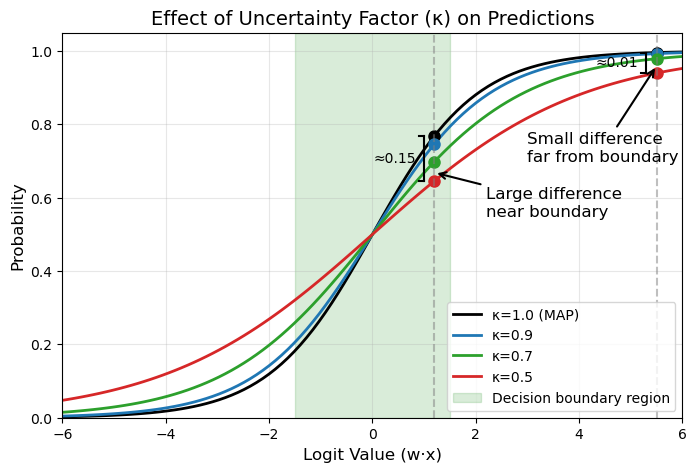

In [16]:
# Generate logit values for the x-axis
x_sigmoid = np.linspace(-6, 6, 100)
y_sigmoid = sigmoid(x_sigmoid)  # Standard sigmoid (kappa=1.0)

# Plot sigmoids with different kappa values - using better colors
kappa_values_demo = [1.0, 0.9, 0.7, 0.5]
colors = ['black', '#1f77b4', '#2ca02c', '#d62728']  # More distinct professional colors
labels = ['κ=1.0 (MAP)', 'κ=0.9', 'κ=0.7', 'κ=0.5']

for i, k in enumerate(kappa_values_demo):
    y_modified = sigmoid(k * x_sigmoid)
    plt.plot(x_sigmoid, y_modified, color=colors[i], linestyle='-', linewidth=2, label=labels[i])

# Highlight specific regions to demonstrate effect - lighter shade
plt.axvspan(-1.5, 1.5, alpha=0.15, color='green', label='Decision boundary region')

# Choose better example points
boundary_point = 1.2  # Near decision boundary
far_point = 5.5       # Far from boundary (moved much further right)

# Calculate and mark points at the boundary region
boundary_ys = [sigmoid(k * boundary_point) for k in kappa_values_demo]
for i, y in enumerate(boundary_ys):
    plt.plot([boundary_point], [y], 'o', color=colors[i], markersize=8)

# Calculate and mark points far from the boundary
far_ys = [sigmoid(k * far_point) for k in kappa_values_demo]
for i, y in enumerate(far_ys):
    plt.plot([far_point], [y], 'o', color=colors[i], markersize=8)

# Add vertical lines to show the exact locations of our example points
plt.axvline(x=boundary_point, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=far_point, color='gray', linestyle='--', alpha=0.5)

# Add explanatory annotations with cleaner positioning
plt.annotate("Large difference\nnear boundary", 
            xy=(boundary_point, boundary_ys[0] - 0.1), 
            xytext=(boundary_point + 1.0, 0.55),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5), 
            fontsize=12)

plt.annotate("Small difference\nfar from boundary", 
            xy=(far_point, far_ys[-1] + 0.02), 
            xytext=(far_point - 2.5, 0.7),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5), 
            fontsize=12)

# Add braces to show the magnitude of differences
def add_brace(x, y1, y2, text):
    y_mid = (y1 + y2) / 2
    plt.plot([x, x], [y1, y2], 'k-', lw=1.5)
    plt.plot([x-0.1, x], [y1, y1], 'k-', lw=1.5)
    plt.plot([x-0.1, x], [y2, y2], 'k-', lw=1.5)
    plt.text(x-0.15, y_mid, text, ha='right', va='center', fontsize=10)

# Add braces showing the difference at boundary point
add_brace(boundary_point-0.2, boundary_ys[0], boundary_ys[-1], "≈0.15")

# Add braces showing the difference at far point
add_brace(far_point-0.2, far_ys[0], far_ys[-1], "≈0.01")  # Updated value for new position

plt.grid(True, alpha=0.3)
plt.xlabel('Logit Value (w·x)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Effect of Uncertainty Factor (κ) on Predictions', fontsize=14)
plt.legend(loc='lower right')
plt.ylim(0, 1.05)
plt.xlim(-6, 6)
plt.show()

For RC/RGB star classification, this behavior is beneficial:
- Stars that are clearly RC or clearly RGB remain confidently classified, even when they're in regions of parameter space with higher uncertainty
- Stars near the classification boundary have their predictions appropriately moderated by uncertainty
- This reduces the chance of overconfident misclassifications in the critical transition region between RC and RGB populations

## The Effect of Prior Strength on Bayesian Logistic Regression

In Bayesian logistic regression, the prior distribution over weights plays a crucial role in both the MAP estimate and the uncertainty quantification. Let's examine how different prior strengths affect our model's behavior by comparing two cases:

The precision parameter $\alpha$ in our Gaussian prior $\mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I})$ controls the strength of our prior beliefs:

- A **weak prior** (small $\alpha$, e.g., 0.001) expresses little preference for particular weight values, allowing the model to be primarily guided by the data
- A **strong prior** (large $\alpha$, e.g., 1.0) strongly prefers weights close to zero, enforcing significant regularization

The prior strength directly affects the MAP estimate, which in turn determines the decision boundary. As we can see in the figure below, increasing the prior strength from weak to strong has several important effects:

1. **Weight magnitude decreases**: With a weak prior, weights have larger magnitudes (e.g., [1.63, -5.27]). With a strong prior, weights are much smaller (e.g., [0.56, -2.10]).

2. **Decision boundary slope changes**: The strong prior makes the boundary less steep, representing a more balanced contribution from both features.

3. **Probability contours widen**: With a strong prior, the transition from low to high probability becomes more gradual, showing less certainty in predictions.

These changes occur because the strong prior effectively tells the model: "Unless the data provides overwhelming evidence, prefer simpler models with smaller weights."

Training model with prior strength α=0.001...
Finding MAP estimate with prior precision alpha=0.001...
Epoch 0: Train Loss = 0.3800, Test Loss = 0.3947
Epoch 20: Train Loss = 0.2328, Test Loss = 0.2410
Epoch 40: Train Loss = 0.2308, Test Loss = 0.2378
Epoch 60: Train Loss = 0.2306, Test Loss = 0.2372
Epoch 80: Train Loss = 0.2306, Test Loss = 0.2371
Training model with prior strength α=1.0...
Finding MAP estimate with prior precision alpha=1.0...
Epoch 0: Train Loss = 0.4013, Test Loss = 0.4156
Epoch 20: Train Loss = 0.3124, Test Loss = 0.3272
Epoch 40: Train Loss = 0.3127, Test Loss = 0.3273
Epoch 60: Train Loss = 0.3122, Test Loss = 0.3267
Epoch 80: Train Loss = 0.3119, Test Loss = 0.3266


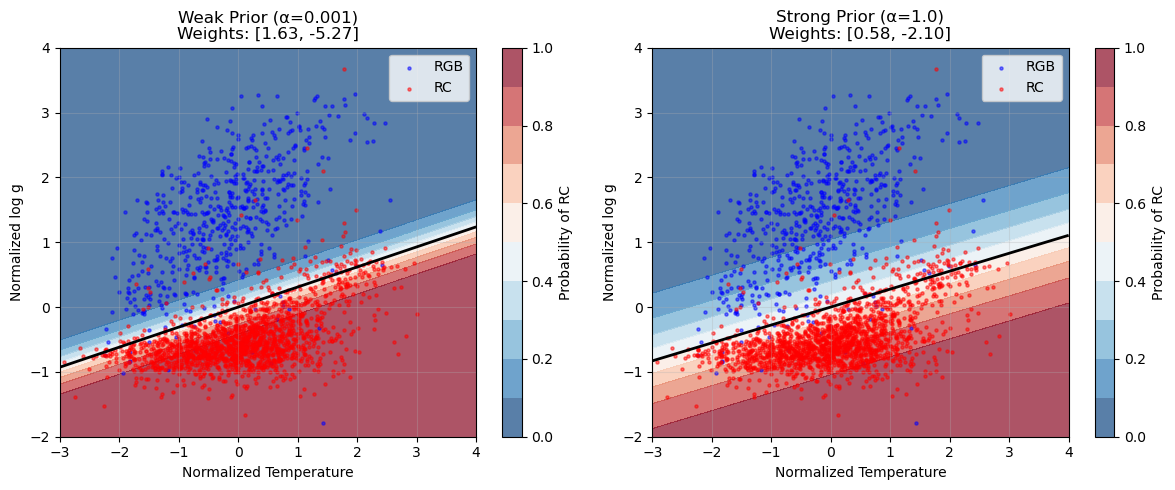

In [17]:
# Compare weak vs. strong priors
alphas = [0.001, 1.0]  # Weak prior, Strong prior
prior_labels = ["Weak Prior (α=0.001)", "Strong Prior (α=1.0)"]
w_maps = []

# Train models with different prior strengths
for alpha_val in alphas:
    print(f"Training model with prior strength α={alpha_val}...")
    
    # Set up training parameters
    learning_rate = 0.1
    n_epochs = 100
    batch_size = 32
    
    # Find MAP estimate with the current alpha
    w_map_current, _, _ = find_map_estimate(
        X_train, t_train, X_test, t_test, 
        learning_rate, n_epochs, batch_size, alpha_val
    )
    w_maps.append(w_map_current)

# Create grid in normalized feature space for visualization
x_min, x_max = -3, 4
y_min, y_max = -2, 4
xx_norm, yy_norm = np.meshgrid(np.linspace(x_min, x_max, 100),
                              np.linspace(y_min, y_max, 100))
# Create visualization comparing decision boundaries with different priors
plt.figure(figsize=(12, 5))

for i, alpha_val in enumerate(alphas):
    plt.subplot(1, 2, i+1)
    
    # Compute probabilities for grid
    grid_points = np.c_[xx_norm.ravel(), yy_norm.ravel()]
    grid_probs = sigmoid(grid_points @ w_maps[i])
    grid_probs = grid_probs.reshape(xx_norm.shape)
    
    # Create contour plot for probabilities
    contour = plt.contourf(xx_norm, yy_norm, grid_probs, levels=np.linspace(0, 1, 11), 
                           cmap='RdBu_r', alpha=0.7)
    plt.colorbar(contour, label='Probability of RC')
    
    # Plot the data points
    plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
               c='blue', s=5, alpha=0.5, label='RGB')
    plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
               c='red', s=5, alpha=0.5, label='RC')
    
    # Draw the decision boundary (probability = 0.5)
    plt.contour(xx_norm, yy_norm, grid_probs, levels=[0.5], colors='k', linewidths=2, 
                linestyles='solid')
    
    # Add title and labels with weight values
    plt.title(f"{prior_labels[i]}\nWeights: [{w_maps[i][0]:.2f}, {w_maps[i][1]:.2f}]")
    plt.xlabel('Normalized Temperature')
    plt.ylabel('Normalized log g')
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Set x-range to -3
    plt.xlim(left=-3)

plt.tight_layout()
plt.show()

## Impact of Prior Strength on Uncertainty Quantification

Having seen how the prior strength affects the decision boundary, let's now examine how it influences uncertainty quantification through the kappa factor.

The kappa parameter represents the "uncertainty factor" in our predictive distribution:

$$ p(t_*=1|\mathbf{x}_*, \mathcal{D}) \approx \sigma(\kappa \cdot \mu_a) $$

Where $\kappa = 1/\sqrt{1 + \pi\sigma_a^2/8}$ and $\sigma_a^2 = \mathbf{x}_*^T \mathbf{A}^{-1} \mathbf{x}_*$.

When we compare the spatial distribution of kappa values between weak and strong priors, we observe important differences:

1. **With a weak prior**: Kappa values are higher overall (closer to 1), indicating higher confidence in predictions, including its predictions in uncertainty. The model places greater trust.

2. **With a strong prior**: Kappa values are lower, especially in regions with sparse data. The model is more cautious about its predictions because the prior introduces additional uncertainty about the weights.

This reveals an important feature of Bayesian logistic regression: a stronger prior acknowledges that it has been substantially influenced by the prior rather than just the data, and therefore expresses less confidence in its predictions and the predictions in uncertainty.

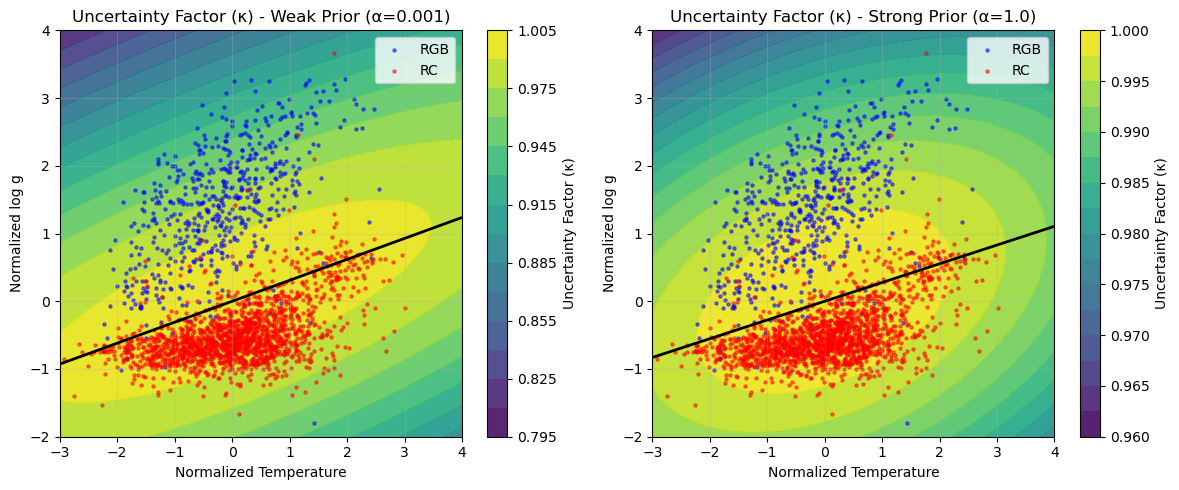

In [18]:
# Compare uncertainty factor (kappa) with weak vs. strong priors
plt.figure(figsize=(12, 5))

# For each prior strength
for i, alpha_val in enumerate(alphas):
    # Use pre-computed w_maps from earlier code
    w_map_current = w_maps[i]
    
    # Compute Hessian and covariance matrix
    hessian_current = compute_hessian(w_map_current, X_train, t_train, alpha_val)
    cov_matrix_current = np.linalg.inv(hessian_current)
    
    # Compute predictive distribution using probit approximation
    _, _, _, kappa_values = compute_predictive_distribution_probit(
        grid_points, w_map_current, cov_matrix_current
    )
    
    # Reshape for plotting
    kappa_values = kappa_values.reshape(xx_norm.shape)
    
    # Create subplot
    plt.subplot(1, 2, i+1)
    
    # Plot kappa values
    kappa_plot = plt.contourf(xx_norm, yy_norm, kappa_values, 
                             cmap='viridis', alpha=0.9, levels=15)
    plt.colorbar(kappa_plot, label='Uncertainty Factor (κ)')
    
    # Plot the data points
    plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
               c='blue', s=5, alpha=0.5, label='RGB')
    plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
               c='red', s=5, alpha=0.5, label='RC')
    
    # Draw the decision boundary
    grid_probs = sigmoid(grid_points @ w_map_current)
    grid_probs = grid_probs.reshape(xx_norm.shape)
    plt.contour(xx_norm, yy_norm, grid_probs, levels=[0.5], 
               colors='k', linewidths=2, linestyles='solid')
    
    # Add title and labels
    plt.title(f"Uncertainty Factor (κ) - {prior_labels[i]}")
    plt.xlabel('Normalized Temperature')
    plt.ylabel('Normalized log g')
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Set x-range to -3
    plt.xlim(left=-3)

plt.tight_layout()
plt.show()

## Comparing Bayesian and MAP Predictions Across Prior Strengths

The final piece of our analysis examines how the difference between Bayesian and MAP predictions varies with prior strength. This difference directly shows where uncertainty quantification has the most impact.

Recall that the Bayesian predictive probability is:
$$ p(t_*=1|\mathbf{x}_*, \mathcal{D}) \approx \sigma(\kappa \cdot \mu_a) $$

While the MAP prediction is simply:
$$ p(t_*=1|\mathbf{x}_*, \mathbf{w}_{\text{MAP}}) = \sigma(\mu_a) $$

The difference between these predictions (Bayesian - MAP) reveals:

1. **With a weak prior**: The differences are smaller and mostly confined to the decision boundary region. The weak prior introduces minimal additional uncertainty beyond what's inherent in the data.

2. **With a strong prior**: The differences are larger and more widespread. We see more significant modifications to the MAP predictions, particularly in regions away from dense data clusters, dominated by the prior.

By narrowing the color scale in our visualization, we'll highlight these subtle but important differences that might otherwise be overlooked. Notice that with both priors, the differences remain most pronounced near the decision boundary, consistent with our earlier observation about the effect of kappa at different logit values.

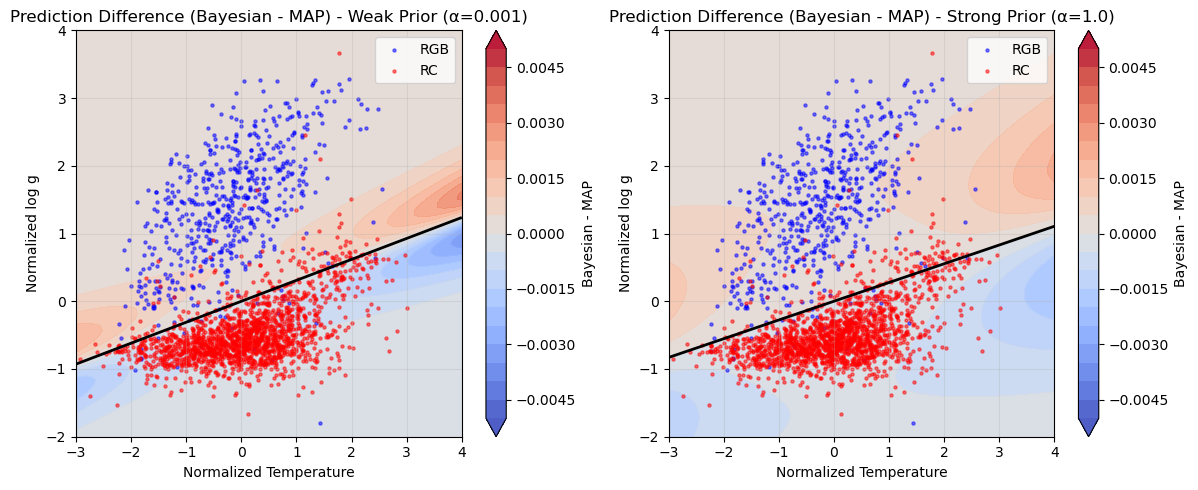

In [19]:
# Compare difference between Bayesian and MAP predictions with different priors
plt.figure(figsize=(12, 5))

# For each prior strength
for i, alpha_val in enumerate(alphas):
    # Use pre-computed w_maps from earlier code
    w_map_current = w_maps[i]
    
    # Compute Hessian and covariance matrix
    hessian_current = compute_hessian(w_map_current, X_train, t_train, alpha_val)
    cov_matrix_current = np.linalg.inv(hessian_current)
    
    # Compute MAP predictions
    map_probs = sigmoid(grid_points @ w_map_current)
    
    # Compute Bayesian predictions using probit approximation
    bayes_probs, _, _, _ = compute_predictive_distribution_probit(
        grid_points, w_map_current, cov_matrix_current
    )
    
    # Calculate difference (Bayesian - MAP)
    diff_probs = bayes_probs - map_probs
    
    # Reshape for plotting
    diff_probs = diff_probs.reshape(xx_norm.shape)
    map_probs = map_probs.reshape(xx_norm.shape)
    
    # Create subplot
    plt.subplot(1, 2, i+1)
    
    # Use a narrower color range to highlight subtle differences
    # Symmetric range ensures zero difference appears as neutral color
    vmin, vmax = -0.005, 0.005  # Narrower range to highlight differences
    
    # Plot difference between Bayesian and MAP predictions
    diff_plot = plt.contourf(xx_norm, yy_norm, diff_probs, 
                            levels=np.linspace(vmin, vmax, 21),
                            cmap='coolwarm', alpha=0.9, extend='both')
    plt.colorbar(diff_plot, label='Bayesian - MAP')
    
    # Plot the data points
    plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
               c='blue', s=5, alpha=0.5, label='RGB')
    plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
               c='red', s=5, alpha=0.5, label='RC')
    
    # Draw the decision boundary
    plt.contour(xx_norm, yy_norm, map_probs, levels=[0.5], 
               colors='k', linewidths=2, linestyles='solid')
    
    # Add title and labels
    plt.title(f"Prediction Difference (Bayesian - MAP) - {prior_labels[i]}")
    plt.xlabel('Normalized Temperature')
    plt.ylabel('Normalized log g')
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Set x-range to -3
    plt.xlim(left=-3)

plt.tight_layout()
plt.show()

## Conclusion: The Value of Bayesian Logistic Regression

In this tutorial, we've explored Bayesian logistic regression for classifying Red Clump (RC) and Red Giant Branch (RGB) stars. Let's summarize the key insights:

1. **From Point Estimates to Distributions**: Unlike standard logistic regression, which gives a single "best" set of weights, Bayesian logistic regression provides a distribution over weights, capturing our uncertainty about the true decision boundary.

2. **The Laplace Approximation**: We used the Laplace approximation to represent our complex posterior distribution as a Gaussian centered at the MAP estimate, with uncertainty captured by the inverse Hessian.

3. **The Predictive Distribution**: Using the probit approximation, we derived a closed-form expression for making predictions that account for parameter uncertainty, automatically reducing confidence in regions with sparse data.

4. **The Role of the Prior**: We observed how different prior strengths affect both the MAP estimate (through regularization) and the uncertainty in our predictions.

Bayesian logistic regression is particularly valuable when:

- You have limited training data
- You need well-calibrated probabilities, not just classifications
- You want to quantify uncertainty in your predictions
- Your training data might not fully represent the target population

These are common scenarios in astronomy, where observations may be sparse, biased, or incomplete, and where understanding the confidence in our classifications directly impacts scientific conclusions.
